# HOAX

## Predictive Model to Check Reports of Environmental Accidents

Data is being retrieved from the database, including reports of environmental accidents managed by IBAMA from Siema. This project proposes the development of a system to validate reports of environmental accidents, with the goal of preventing the misuse of public resources.

### Data Processing

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from keras import optimizers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [2]:
# Calculating notebook runtime

start = time.time()

In [3]:
# Auxiliary functions

def is_str(data):
    return 1 if pd.notna(data) and data != "Não há descrição" else 0

def first_str(data):
    return data.split(';')[0]

def count_str(data):
    return len(data.split(';')) if pd.notna(data) else 0

In [4]:
file = 'data/acidenteambiental.csv'
url  = 'http://siscom.ibama.gov.br/geoserver/publica/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=publica:adm_comunicacidente_p&outputFormat=csv'

cols = [
    'institiuicoes_atuando_local', 'iniciados_outras_providencias', 'origem',
    'plano_emergencia_acionado', 'informacao_responsavel', 'ocorrencia_oleo',
    'informacao_geografica', 'tipos_fontes_informacoes', 'des_ocorrencia',
    'uf', 'tipos_danos_identificados', 'periodo_ocorrencia', 'validado'
]

notifications = pd.read_csv(file, low_memory=False, usecols=cols)[cols]
notifications.head()

,institiuicoes_atuando_local,iniciados_outras_providencias,origem,plano_emergencia_acionado,informacao_responsavel,ocorrencia_oleo,informacao_geografica,tipos_fontes_informacoes,des_ocorrencia,uf,tipos_danos_identificados,periodo_ocorrencia,validado
0,Corpo de Bombeiros;Polícia Rodoviária,N,Rodovia,N,N,N,S,Mídia,Tombamento de caminhão carregado de biocombust...,AL,Óbitos/feridos,M,S
1,Corpo de Bombeiros,N,Armazenamento/depósito,N,N,N,S,Mídia,Explosão em depósito de gás.,ES,Outro(s),M,S
2,Outra(s),N,Outro(s),N,N,N,S,Mídia,Vazamento de esgoto em grande quantidade causa...,MS,Fauna;Flora;População afetada/evacuada;Rio/cór...,M,S
3,Corpo de Bombeiros;Defesa Civil,N,Rodovia,N,N,N,S,Mídia,Tombamento de caminhão carregado de combustíve...,DF,Solo,M,S
4,Outra(s),N,Outro(s),N,N,N,S,Mídia,300 Kg de produtos poluidores encontrados ás m...,RS,Rio/córrego;Solo,M,S


In [5]:
notifications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13127 entries, 0 to 13126
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   institiuicoes_atuando_local    11548 non-null  object
 1   iniciados_outras_providencias  13127 non-null  object
 2   origem                         12980 non-null  object
 3   plano_emergencia_acionado      13127 non-null  object
 4   informacao_responsavel         13127 non-null  object
 5   ocorrencia_oleo                13127 non-null  object
 6   informacao_geografica          6861 non-null   object
 7   tipos_fontes_informacoes       12812 non-null  object
 8   des_ocorrencia                 5775 non-null   object
 9   uf                             12340 non-null  object
 10  tipos_danos_identificados      12211 non-null  object
 11  periodo_ocorrencia             12418 non-null  object
 12  validado                       13127 non-null  object
dtypes

An initial look at the dataframe allows observing the lack of uniformity in the treatment of boolean data:

 - `plano_emergencia_acionado`     $\rightarrow [N, S]$
 - `iniciados_outras_providencias` $\rightarrow [N, S]$
 - `ocorrencia_oleo`               $\rightarrow [N, S]$
 - `informacao_geografica`         $\rightarrow [nan, S]$
 - `informacao_responsavel`        $\rightarrow [N, T]$
 - `validado`                      $\rightarrow [N, S]$

In [6]:
notifications['plano_emergencia_acionado'] = notifications['plano_emergencia_acionado'].map({'N' : 0,
                                                                                             'S' : 1})

notifications['plano_emergencia_acionado']

0        0
1        0
2        0
3        0
4        0
        ..
13122    0
13123    0
13124    0
13125    0
13126    0
Name: plano_emergencia_acionado, Length: 13127, dtype: int64

In [7]:
notifications['iniciados_outras_providencias'] = notifications['iniciados_outras_providencias'].map({'N' : 0,
                                                                                                     'S' : 1})

notifications['iniciados_outras_providencias']

0        0
1        0
2        0
3        0
4        0
        ..
13122    0
13123    1
13124    0
13125    1
13126    1
Name: iniciados_outras_providencias, Length: 13127, dtype: int64

In [8]:
notifications['ocorrencia_oleo'] = notifications['ocorrencia_oleo'].map({'N' : 0,
                                                                         'S' : 1})

notifications['ocorrencia_oleo']

0        0
1        0
2        0
3        0
4        0
        ..
13122    1
13123    0
13124    0
13125    0
13126    0
Name: ocorrencia_oleo, Length: 13127, dtype: int64

In [9]:
notifications['informacao_geografica'] = notifications['informacao_geografica'].map({np.nan : 0,
                                                                                     'S' : 1})

notifications['informacao_geografica']

0        1
1        1
2        1
3        1
4        1
        ..
13122    0
13123    0
13124    0
13125    0
13126    0
Name: informacao_geografica, Length: 13127, dtype: int64

In [10]:
notifications['informacao_responsavel'] = notifications['informacao_responsavel'].map({'N' : 0,
                                                                                       'T' : 1})

notifications['informacao_responsavel']

0        0
1        0
2        0
3        0
4        0
        ..
13122    1
13123    1
13124    0
13125    1
13126    1
Name: informacao_responsavel, Length: 13127, dtype: int64

In [11]:
notifications['validado'] = notifications['validado'].map({'N' : 0,
                                                           'S' : 1})

notifications['validado']

0        1
1        1
2        1
3        1
4        1
        ..
13122    1
13123    1
13124    0
13125    1
13126    1
Name: validado, Length: 13127, dtype: int64

In [12]:
notifications.dropna(subset=['periodo_ocorrencia'], inplace=True)

le_period = LabelEncoder()
le_period.fit(notifications['periodo_ocorrencia'])

notifications['periodo_ocorrencia'] = le_period.transform(notifications['periodo_ocorrencia'])  

for label, count in notifications['periodo_ocorrencia'].value_counts().items():  # S -> Sembrol (00:00 to 05:59)
    print(f'{label} ({le_period.inverse_transform([label])[0]}) -> {count}')

0 (M) -> 8178
3 (V) -> 2119
1 (N) -> 1094
2 (S) -> 1027


In [13]:
notifications.dropna(subset=['uf'], inplace=True)

le_uf = LabelEncoder()
le_uf.fit(notifications['uf'])

notifications['uf'] = le_uf.transform(notifications['uf'])

for label, count in notifications['uf'].value_counts().items():
    print(f'{label} ({le_uf.inverse_transform([label])[0]}) -> {count}')

10 (MG) -> 3217
25 (SP) -> 2241
18 (RJ) -> 1936
17 (PR) -> 606
22 (RS) -> 484
4 (BA) -> 463
23 (SC) -> 402
7 (ES) -> 385
11 (MS) -> 212
24 (SE) -> 209
8 (GO) -> 182
5 (CE) -> 171
6 (DF) -> 137
12 (MT) -> 136
9 (MA) -> 133
19 (RN) -> 132
2 (AM) -> 125
1 (AL) -> 120
13 (PA) -> 103
15 (PE) -> 83
26 (TO) -> 58
20 (RO) -> 49
14 (PB) -> 46
16 (PI) -> 36
3 (AP) -> 12
21 (RR) -> 8
0 (AC) -> 5


In [14]:
# Get the information if it has a description or not

notifications['des_ocorrencia'] = notifications['des_ocorrencia'].apply(is_str)

notifications['des_ocorrencia'].value_counts()

des_ocorrencia
0    5918
1    5773
Name: count, dtype: int64

In [15]:
notifications['origem'].unique()

array(['Rodovia', 'Armazenamento/depósito', 'Outro(s)', 'Indústria',
       'Plataforma', 'Embarcação', 'Ferrovia',
       'Terminal/portos/ancoradouros/etc', 'Duto', 'Posto de combustível',
       'Barragem', 'Refinaria', nan, 'Ferrovia;Rodovia',
       'Embarcação;Terminal/portos/ancoradouros/etc',
       'Embarcação;Plataforma', 'Ferrovia;Outro(s)', 'Duto;Outro(s)',
       'Posto de combustível;Rodovia',
       'Armazenamento/depósito;Terminal/portos/ancoradouros/etc',
       'Embarcação;Outro(s)', 'Outro(s);Plataforma',
       'Armazenamento/depósito;Barragem', 'Indústria;Outro(s)',
       'Armazenamento/depósito;Rodovia',
       'Armazenamento/depósito;Outro(s)',
       'Barragem;Terminal/portos/ancoradouros/etc', 'Indústria;Rodovia',
       'Armazenamento/depósito;Indústria', 'Outro(s);Rodovia',
       'Outro(s);Terminal/portos/ancoradouros/etc',
       'Posto de combustível;Terminal/portos/ancoradouros/etc',
       'Duto;Plataforma', 'Plataforma;Terminal/portos/ancoradouros/etc'

In [16]:
# Getting first origin description
# Taking into account the assumption that a hierarchical order exists within the classification system

notifications.dropna(subset=['origem'], inplace=True)

notifications['origem'] = notifications['origem'].apply(first_str)

le_origin = LabelEncoder()
le_origin.fit(notifications['origem'])

notifications['origem'] = le_origin.transform(notifications['origem'])

for label, count in notifications['origem'].value_counts().items():
    print(f'{label} ({le_origin.inverse_transform([label])[0]}) -> {count}')

10 (Rodovia) -> 4104
6 (Outro(s)) -> 1992
7 (Plataforma) -> 1380
4 (Ferrovia) -> 1114
5 (Indústria) -> 811
3 (Embarcação) -> 790
2 (Duto) -> 613
11 (Terminal/portos/ancoradouros/etc) -> 279
0 (Armazenamento/depósito) -> 215
1 (Barragem) -> 142
8 (Posto de combustível) -> 137
9 (Refinaria) -> 39


In [17]:
notifications['institiuicoes_atuando_local'].unique()[:10]

array(['Corpo de Bombeiros;Polícia Rodoviária', 'Corpo de Bombeiros',
       'Outra(s)', 'Corpo de Bombeiros;Defesa Civil', 'IBAMA;Outra(s)',
       'Corpo de Bombeiros;Defesa Civil;Outra(s);Polícia Civil',
       'Outra(s);Polícia Rodoviária',
       'Corpo de Bombeiros;Outra(s);Polícia Militar',
       'Corpo de Bombeiros;Outra(s)', 'IBAMA'], dtype=object)

In [18]:
# We obtain relevant information on how many institutions are operating in the area

notifications['institiuicoes_atuando_local'] = notifications['institiuicoes_atuando_local'].apply(count_str)

notifications.rename(columns={'institiuicoes_atuando_local' : 'quant_instituicoes_atuando_local'},
                     inplace=True)

notifications['quant_instituicoes_atuando_local']

0        2
1        1
2        1
3        2
4        1
        ..
13119    0
13123    1
13124    0
13125    1
13126    1
Name: quant_instituicoes_atuando_local, Length: 11616, dtype: int64

In [19]:
# Same strategy as column 'institiuicoes_atuando_local'

notifications['tipos_fontes_informacoes'] = notifications['tipos_fontes_informacoes'].apply(count_str)

notifications.rename(columns={'tipos_fontes_informacoes' : 'quant_fontes_informacoes'},
                     inplace=True)

notifications['quant_fontes_informacoes']

0        1
1        1
2        1
3        1
4        1
        ..
13119    1
13123    1
13124    1
13125    1
13126    0
Name: quant_fontes_informacoes, Length: 11616, dtype: int64

In [20]:
# Same strategy as column 'institiuicoes_atuando_local'

notifications['tipos_danos_identificados'] = notifications['tipos_danos_identificados'].apply(count_str)

notifications.rename(columns={'tipos_danos_identificados' : 'quant_tipos_danos_identificados'},
                     inplace=True)

notifications['quant_tipos_danos_identificados']

0        1
1        1
2        4
3        1
4        2
        ..
13119    2
13123    2
13124    1
13125    1
13126    3
Name: quant_tipos_danos_identificados, Length: 11616, dtype: int64

### EDA

In [21]:
# Database obtained after pre-processing

notifications.head()

,quant_instituicoes_atuando_local,iniciados_outras_providencias,origem,plano_emergencia_acionado,informacao_responsavel,ocorrencia_oleo,informacao_geografica,quant_fontes_informacoes,des_ocorrencia,uf,quant_tipos_danos_identificados,periodo_ocorrencia,validado
0,2,0,10,0,0,0,1,1,1,1,1,0,1
1,1,0,0,0,0,0,1,1,1,7,1,0,1
2,1,0,6,0,0,0,1,1,1,11,4,0,1
3,2,0,10,0,0,0,1,1,1,6,1,0,1
4,1,0,6,0,0,0,1,1,1,22,2,0,1


Checking the distribution of validated occurrences:

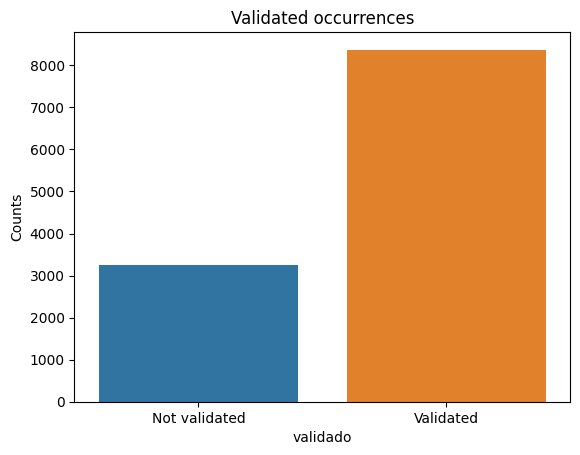

In [22]:
sns.countplot(x=notifications.validado)

plt.title("Validated occurrences")
plt.xticks(ticks=[0, 1], labels=["Not validated", "Validated"])
plt.ylabel("Counts")

plt.show()

Checking attribute distribution:

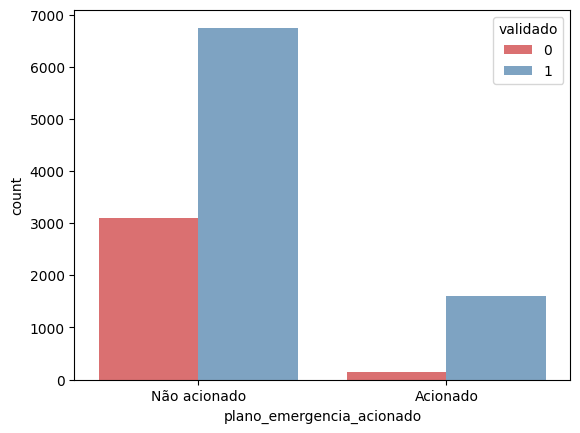

In [23]:
sns.countplot(data=notifications, x="plano_emergencia_acionado",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não acionado", "Acionado"])

plt.show()

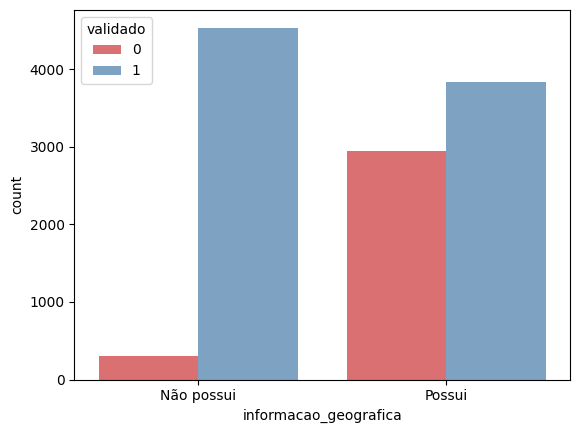

In [24]:
sns.countplot(data=notifications, x="informacao_geografica",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não possui", "Possui"])

plt.show()

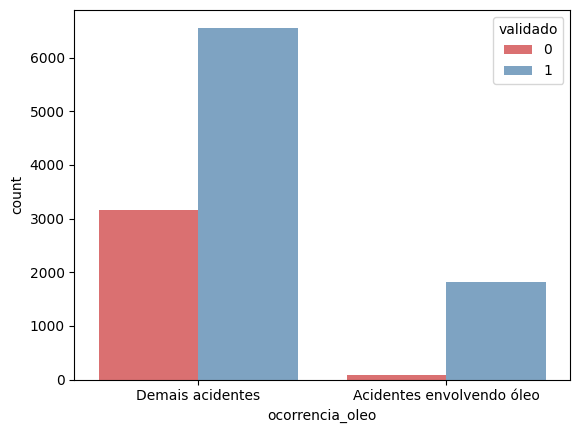

In [25]:
sns.countplot(data=notifications, x="ocorrencia_oleo",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Demais acidentes", "Acidentes envolvendo óleo"])

plt.show()

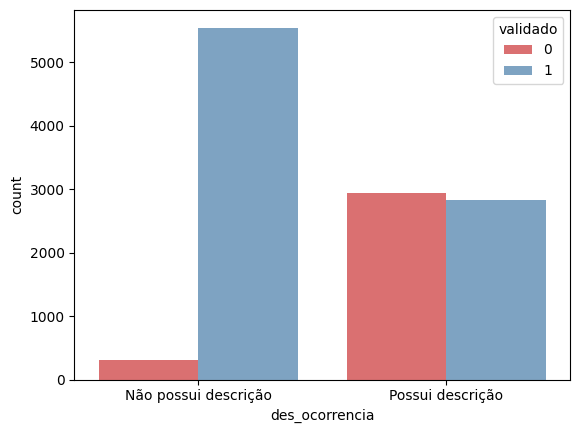

In [26]:
sns.countplot(data=notifications, x="des_ocorrencia",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não possui descrição", "Possui descrição"])

plt.show()

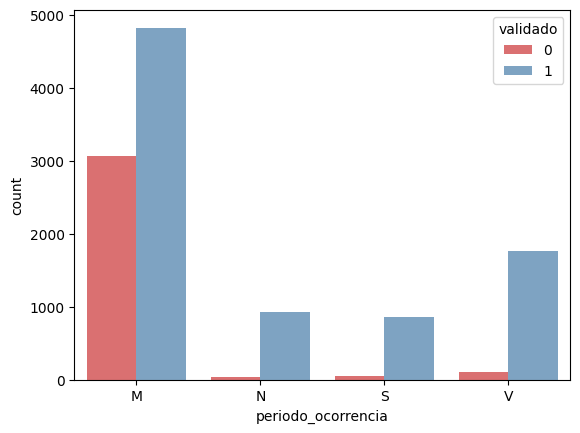

In [27]:
sns.countplot(data=notifications, x="periodo_ocorrencia",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks(np.arange(len(le_period.classes_)), le_period.classes_)

plt.show()

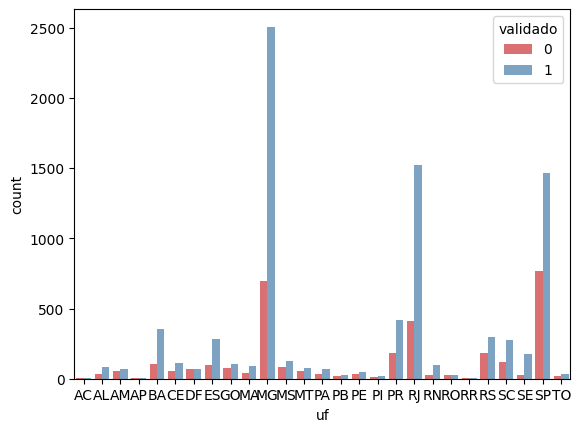

In [28]:
sns.countplot(data=notifications, x="uf",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks(np.arange(len(le_uf.classes_)), le_uf.classes_)

plt.show()

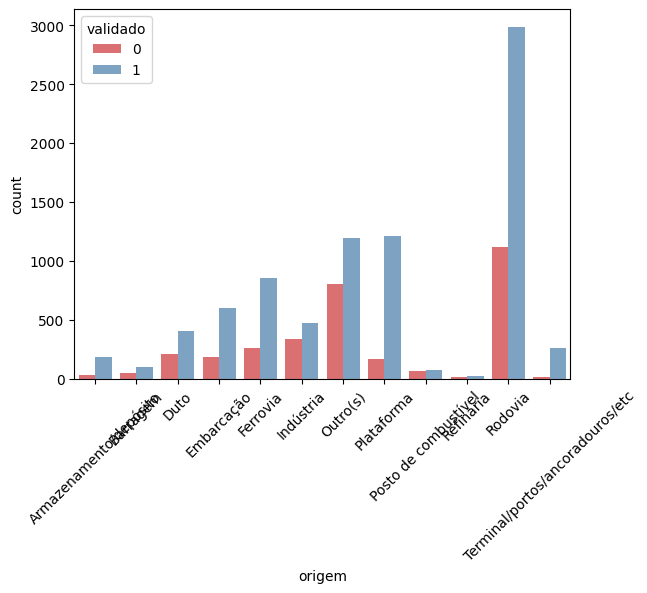

In [29]:
sns.countplot(data=notifications, x="origem",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks(np.arange(len(le_origin.classes_)), le_origin.classes_, rotation=45)

plt.show()

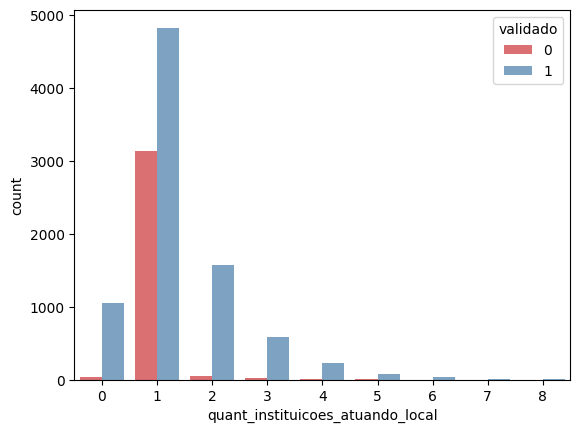

In [30]:
sns.countplot(data=notifications, x="quant_instituicoes_atuando_local",
              hue="validado", palette='Set1', alpha =.7)

plt.show()

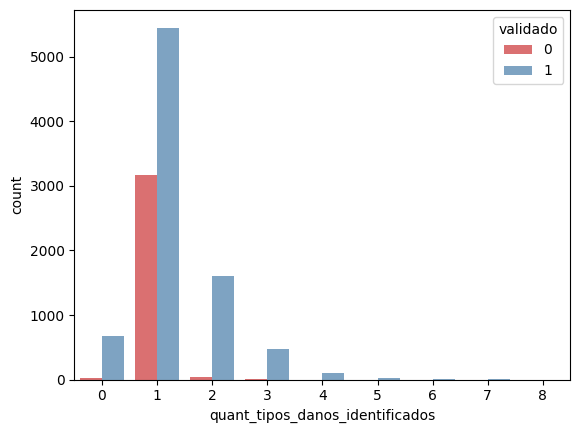

In [31]:
sns.countplot(data=notifications, x="quant_tipos_danos_identificados",
              hue="validado", palette='Set1', alpha =.7)

plt.show()

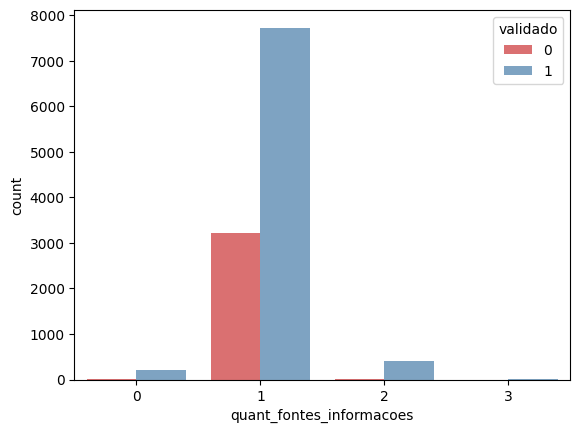

In [32]:
sns.countplot(data=notifications, x="quant_fontes_informacoes",
              hue="validado", palette='Set1', alpha =.7)

plt.show()

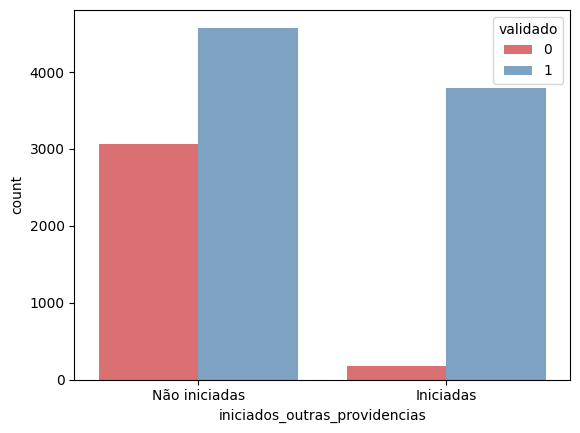

In [33]:
sns.countplot(data=notifications, x="iniciados_outras_providencias",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não iniciadas", "Iniciadas"])

plt.show()

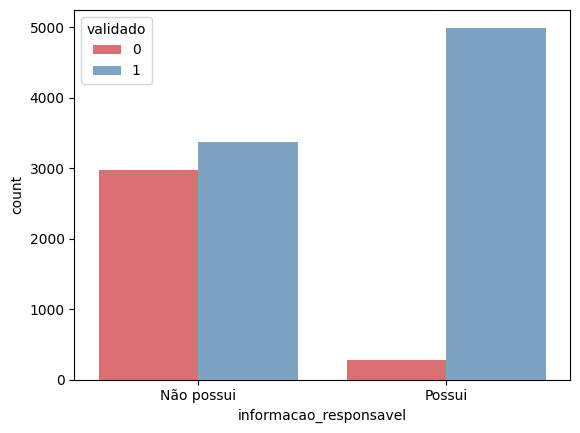

In [34]:
sns.countplot(data=notifications, x="informacao_responsavel",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não possui", "Possui"])

plt.show()

Checking the correlation matrix:

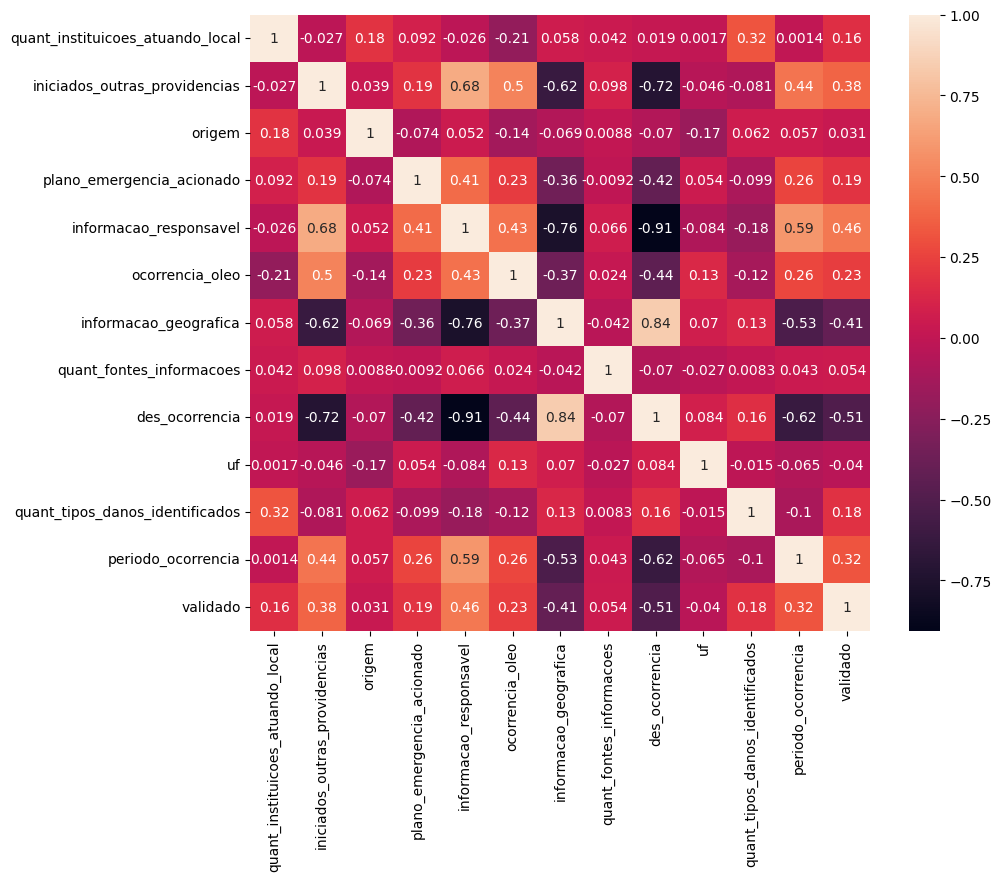

In [35]:
plt.figure(figsize=(10, 8))

corr = notifications.corr()
sns.heatmap(corr, annot=True)

plt.show()

### Data Processing for ML Models

In [36]:
# Building the inputs for the classifier
# It was not considered necessary to normalize or standardize the data

X = notifications.drop(["validado"], axis=1).to_numpy()
y = notifications["validado"].to_numpy()

N, p = X.shape

print("Number of samples:", N)
print("Number of parameters:", p)

Number of samples: 11616
Number of parameters: 12


In [37]:
# Separating data between training and testing
# The decision to split the data before all classifiers is to ensure that all classifiers train on the same data
# N obtained by the golden rule applied to each of the models will allow us to use 30% of the data for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

N_train, N_test = X_train.shape[0], X_test.shape[0]

print("Number of samples in training:", N_train)
print("Number of samples in the test:", N_test)

Number of samples in training: 8131
Number of samples in the test: 3485


### DTC

In [38]:
# Getting the VC dimension for decision trees
# As the training set has size 8131 the golden rule is satisfied

summ = sum(2**(len(notifications[col].unique()) - 1)
           for col in notifications)

d_vc = int(np.log(summ + 1) + 1)

print("VC dimension:", d_vc)
print("By the golden rule: N >=", d_vc*10)

VC dimension: 19
By the golden rule: N >= 190


In [39]:
# Building a decision tree with the training instance

clf_tree = DecisionTreeClassifier()

clf_tree.fit(X_train, y_train)

DecisionTreeClassifier()

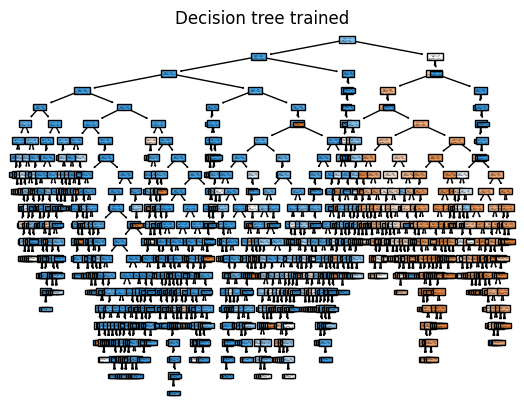

In [40]:
plot_tree(clf_tree, filled=True)
plt.title("Decision tree trained")

plt.show()

In [41]:
# Computing `𝐸𝑖𝑛` and `𝐸𝑜𝑢𝑡` to analyze for overfitting
# The results obtained allow us to infer that there was no overfitting
# The difference between Ein and Eout was low (less than 5%)

print("Analyzing the results obtained with DecisionTreeClassifier:")

print()
print(f"Ein = {(1 - clf_tree.score(X_train, y_train))*100:.2f}%")
print(f"Eout = {(1 - clf_tree.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, clf_tree.predict(X_test)),
                   index=['f(x)=0', 'f(x)=1'],
                   columns=['h(x)=0', 'h(x)=1']))

print()
print(classification_report(y_test, clf_tree.predict(X_test)))

Analyzing the results obtained with DecisionTreeClassifier:

Ein = 9.04%
Eout = 12.60%

        h(x)=0  h(x)=1
f(x)=0     849     141
f(x)=1     298    2197

              precision    recall  f1-score   support

           0       0.74      0.86      0.79       990
           1       0.94      0.88      0.91      2495

    accuracy                           0.87      3485
   macro avg       0.84      0.87      0.85      3485
weighted avg       0.88      0.87      0.88      3485



Regularizing the value of 𝛼 using the Minimal Cost-Complexity algorithm, the golden rule, where $K = \frac{N}{5}$​, is applied in this process.

In [42]:
clf = DecisionTreeClassifier()
ccp_alphas = clf.cost_complexity_pruning_path(X_train, y_train).ccp_alphas

param_grid = {'ccp_alpha' : ccp_alphas[ccp_alphas > 0]}

CV_clf_tree = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
CV_clf_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([1.93526519e-08, 1.00478842e-07, 1.88484448e-07, 2.30887552e-07,
       2.92669202e-07, 3.78418777e-07, 3.94186226e-07, 4.50498544e-07,
       4.55504084e-07, 4.73023471e-07, 6.75747816e-07, 7.20797671e-07,
       7.45370319e-07, 7.98611056e-07, 8.19907350e-07, 8.23976370e-07,
       8.50134350e-07, 9.67548010e...
       1.58124989e-04, 1.59938698e-04, 1.63543499e-04, 1.65956347e-04,
       1.68262232e-04, 1.70041649e-04, 1.72196444e-04, 1.73274947e-04,
       1.89975880e-04, 2.02790955e-04, 2.12656539e-04, 2.24380167e-04,
       2.59152172e-04, 2.96146287e-04, 3.24005181e-04, 3.51938874e-04,
       3.99420119e-04, 4.20789563e-04, 5.00097117e-04, 1.02360453e-03,
       2.61570011e-03, 3.77181510e-03, 7.25998679e-03, 4.39554121e-02,
       7.34999683e-02, 1.03478819e-01])})

In [43]:
results = pd.DataFrame(CV_clf_tree.cv_results_)
results = results.sort_values(by=["rank_test_score"])
results = results.set_index(results["params"].apply(lambda x: x['ccp_alpha']))

results[["mean_test_score", "std_test_score"]]

,mean_test_score,std_test_score
params,,
1.023605e-03,0.894354,0.007398
3.771815e-03,0.893862,0.007370
2.615700e-03,0.892878,0.007661
5.000971e-04,0.892633,0.006066
4.207896e-04,0.892633,0.006066
...,...,...
4.392361e-06,0.869019,0.005442
8.501343e-07,0.869019,0.004858
4.395541e-02,0.855240,0.031310


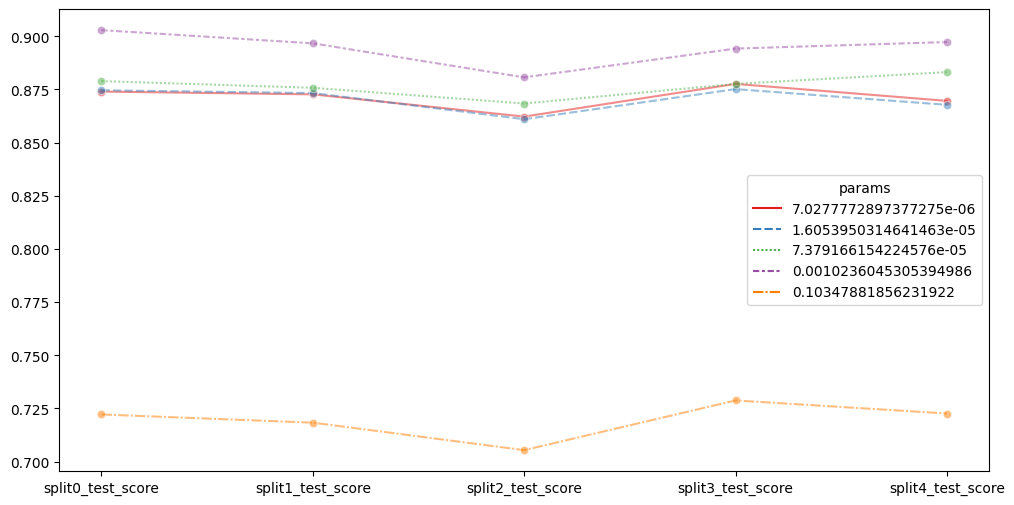

In [44]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=results.transpose().iloc[6:11, np.linspace(0, results.shape[0]-1, 5, dtype='int64')],
             palette="Set1", marker="o", alpha=0.5)

plt.show()

Plotting the tree and computing the quality metrics of the best built tree:

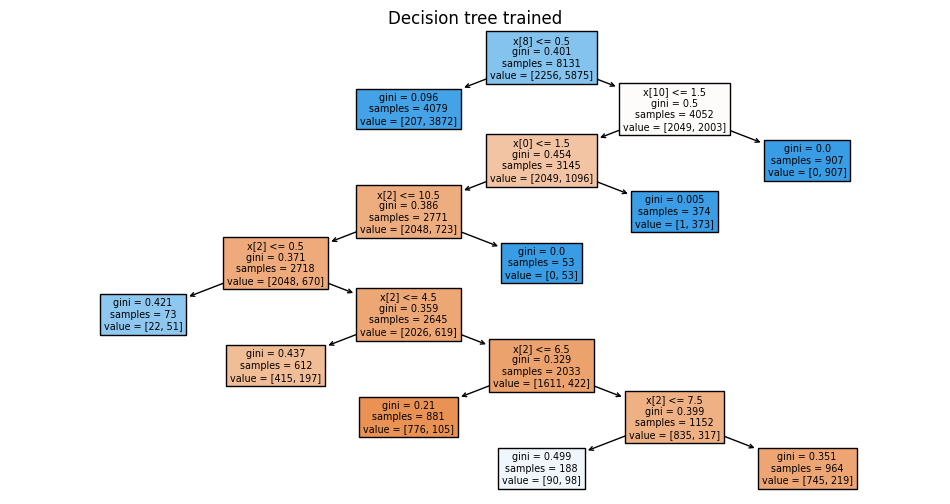

In [45]:
plt.figure(figsize=(12, 6))

plot_tree(CV_clf_tree.best_estimator_, filled=True)
plt.title("Decision tree trained")
plt.show()

In [46]:
print("Getting the relevants features:")

print()

for i, v in enumerate(CV_clf_tree.best_estimator_.feature_importances_):
    if v:
        print(f"X[{i}] = {notifications.columns[i]} ({v})")

Getting the relevants features:

X[0] = quant_instituicoes_atuando_local (0.18329028687085627)
X[2] = origem (0.07872339796768338)
X[8] = des_ocorrencia (0.43149777069997564)
X[10] = quant_tipos_danos_identificados (0.30648854446148466)


In [47]:
# The regularization process allowed to increase the accuracy in the test when it got a little worse in training
# Thus, the generalization becomes even greater when the errors in training and testing are very close

print("Analyzing the results obtained with DecisionTreeClassifier:")

print()
print(f"Best parameters: {CV_clf_tree.best_estimator_}")

print()
print(f"Ein = {(1 - CV_clf_tree.score(X_train, y_train))*100:.2f}%")
print(f"Eout = {(1 - CV_clf_tree.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, CV_clf_tree.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, CV_clf_tree.predict(X_test)))

Analyzing the results obtained with DecisionTreeClassifier:

Best parameters: DecisionTreeClassifier(ccp_alpha=0.0010236045305394986)

Ein = 10.34%
Eout = 10.62%

         h(x)=0  h(x)=+1
f(x)=0      846      144
f(x)=+1     226     2269

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       990
           1       0.94      0.91      0.92      2495

    accuracy                           0.89      3485
   macro avg       0.86      0.88      0.87      3485
weighted avg       0.90      0.89      0.90      3485



### SVM

Getting the VC dimension for Support Vector Machine assuming the data is linearly separable

$$D_{vc} = d+1$$

Using the default kernel of sklearn `kernel='rbf'` we know that finding VC dimension is non-trivial and RBF have infinite VC dimension but still work well in practice.

In [48]:
# We verify that the size of the training set allows generalization

d_vc = X.shape[1] + 1

print("VC dimension:", d_vc)
print("By the golden rule: N >=", d_vc*10)

VC dimension: 13
By the golden rule: N >= 130


In [49]:
# Building a SVM with the training instance

clf_svm = SVC()

clf_svm.fit(X_train,y_train)

SVC()

In [50]:
# The results obtained allow us to infer that there was no overfitting
# The difference between Ein and Eout was low

print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(f"E_in = {(1 - clf_svm.score(X_train, y_train))*100:.2f}%")
print(f"E_out = {(1 - clf_svm.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, clf_svm.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, clf_svm.predict(X_test)))

Analyzing the results obtained with SupportVectorMachine:

E_in = 14.41%
E_out = 14.15%

         h(x)=0  h(x)=+1
f(x)=0      890      100
f(x)=+1     393     2102

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       990
           1       0.95      0.84      0.90      2495

    accuracy                           0.86      3485
   macro avg       0.82      0.87      0.84      3485
weighted avg       0.88      0.86      0.86      3485



To try to get a better classifier we will use cross-validating and testing various parameterization combinations. The golden rule, where $K = \frac{N}{5}$, is applied in this process.

In [51]:
# Using kernel RBF Gaussian for non-linear problems

param_grid = {'C' : [1, 2, 5, 10],
              'gamma' : [0.1, 0.01, 1, 5]}

CV_clf_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5)

CV_clf_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 2, 5, 10], 'gamma': [0.1, 0.01, 1, 5]})

In [52]:
# Better results were obtained after the regularization of the C and gamma parameters
# The results obtained allow us to infer that there was no overfitting
# The difference between Ein and Eout was low
# As the Eout is smaller than the expected Eout, then generalization is guaranteed

print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(f"Best parameters: {CV_clf_svm.best_estimator_}")

print()
print(f"E_in = {(1 - CV_clf_svm.score(X_train, y_train))*100:.2f}%")
print(f"E_out = {(1 - CV_clf_svm.score(X_test, y_test))*100:.2f}%")
print(f"E[E_out_] <= {(len(CV_clf_svm.best_estimator_.support_vectors_) / len(X_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, CV_clf_svm.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, CV_clf_svm.predict(X_test)))

Analyzing the results obtained with SupportVectorMachine:

Best parameters: SVC(C=5, gamma=0.1)

E_in = 10.24%
E_out = 10.36%
E[E_out_] <= 29.69%

         h(x)=0  h(x)=+1
f(x)=0      890      100
f(x)=+1     261     2234

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       990
           1       0.96      0.90      0.93      2495

    accuracy                           0.90      3485
   macro avg       0.87      0.90      0.88      3485
weighted avg       0.90      0.90      0.90      3485



### NN

Getting the maximum number of neurons for a single-layer network

$$n \leq \left \lfloor {\frac{{\lvert}DS{\rvert}-10}{10(d+2)}}  \right \rfloor$$

It is known that the VC dimension for a network with a single layer is

$$D_{vc} = [(d+1)n + (n+1)]$$

By the golden rule let's get the minimun value for examples:

$$N >= 10d_{VC}$$

In [53]:
# As the training set has size 8246 the golden rule is satisfied

DS = len(X_train)
d = X_train.shape[1]

n = int((DS-10) / (10*(d+2)))
d_vc = (d+1)*n + (n+1)

print(f"Number of neurons in the hidden layer: {n}")
print("VC dimension assuming use of all possible neurons:", d_vc)

Number of neurons in the hidden layer: 58
VC dimension assuming use of all possible neurons: 813


In [54]:
# Auxiliary functions for building models (neural network with a single hidden layer)

def create_model(n, d):
    model = Sequential()

    model.add(Dense(n, input_dim=d, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    adam = optimizers.Adam(learning_rate=0.01)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [55]:
# Network configured based on information from the VC dimension and the golden rule

clf_neural = create_model(n, d)

print(clf_neural.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 58)                754       
                                                                 
 dense_1 (Dense)             (None, 1)                 59        
                                                                 
Total params: 813 (3.18 KB)
Trainable params: 813 (3.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [56]:
history = clf_neural.fit(X_train, y_train, epochs=500, batch_size=1024)

Epoch 1/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6005 - accuracy: 0.6829
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 0.5241 - accuracy: 0.7228
Epoch 3/500
8/8 [==============================] - 0s 1ms/step - loss: 0.4339 - accuracy: 0.7898
Epoch 4/500
8/8 [==============================] - 0s 1ms/step - loss: 0.3929 - accuracy: 0.8853
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 0.3761 - accuracy: 0.8816
Epoch 6/500
8/8 [==============================] - 0s 1ms/step - loss: 0.3637 - accuracy: 0.8845
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 0.3551 - accuracy: 0.8822
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 0.3491 - accuracy: 0.8843
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 0.3429 - accuracy: 0.8845
Epoch 10/500
8/8 [==============================] - 0s 1ms/step - loss: 0.3368 - accuracy: 0.8850
Epoch 11/500
8/8 [===========

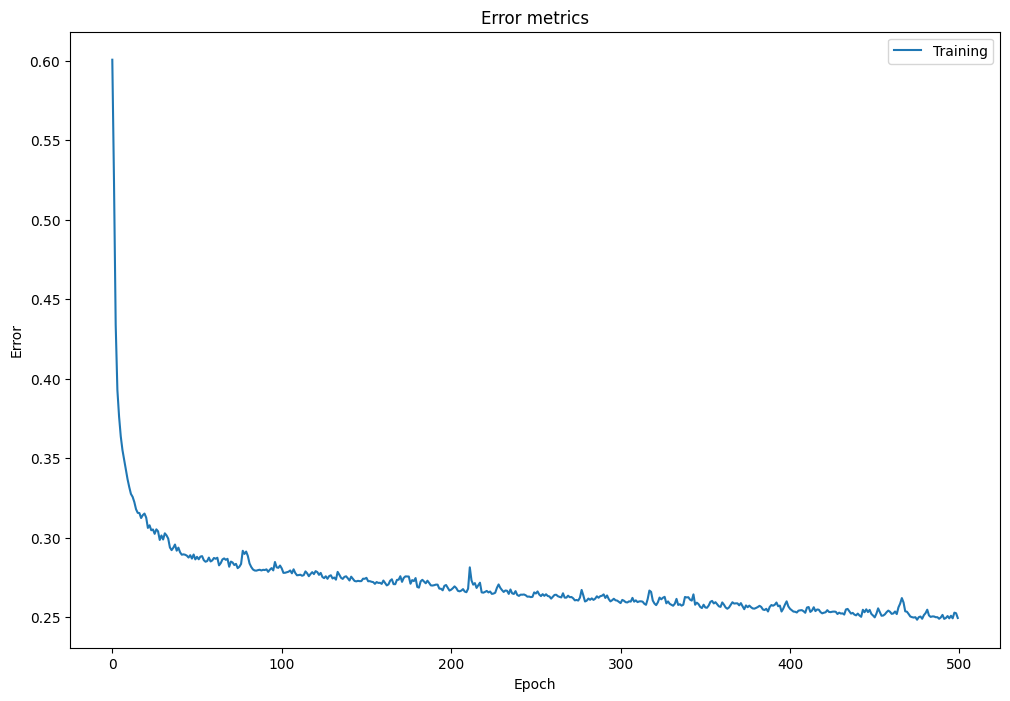

In [57]:
plt.figure(figsize=(12, 8))

plt.plot(history.history['loss'])

plt.title('Error metrics')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Training'])

plt.show()

In [58]:
pred_train = np.round(clf_neural.predict(X_train, verbose=0))
pred_test = np.round(clf_neural.predict(X_test, verbose=0))

print("Analyzing the results obtained with NeuralNetwork:")

print()
print(f"E_in = {(1 - accuracy_score(y_train, pred_train))*100:.2f}%")
print(f"E_out = {(1 - accuracy_score(y_test, pred_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, pred_test),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))
print(f'\n{classification_report(y_test, pred_test)}')

Analyzing the results obtained with NeuralNetwork:

E_in = 10.69%
E_out = 11.02%

         h(x)=0  h(x)=+1
f(x)=0      880      110
f(x)=+1     274     2221

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       990
           1       0.95      0.89      0.92      2495

    accuracy                           0.89      3485
   macro avg       0.86      0.89      0.87      3485
weighted avg       0.90      0.89      0.89      3485



During the construction of the ML model, it was tested using the ``batch_size`` as the size of the training set (using all the data) and it was verified that when decreasing this size the result improves by less than 1%.

In this way, the second highest power of 3 below the size of the training set ($2^{10}$) was chosen for the argument, this large value for the `batch_size` allowed us to considerably increase the number of epochs without compromising the efficiency of the algorithm (we used `epochs=500`).

The results obtained allow us to infer that there was no overfitting, as the difference between `Ein` and `Eout`. In this way, a more accurate analysis of the evolution of the model over time is not necessary.

In [59]:
def create_huge_model(n, d):
    model = Sequential()

    model.add(Dense(2*n, input_dim=d, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(2*n, input_dim=d, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    adam = optimizers.Adam(learning_rate=0.01)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [60]:
# Training a network with two layers each with twice as many neurons allowed in the hidden layer
# The results are checked after applying the regularization process

clf_neural = create_huge_model(n, d)

print(clf_neural.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 116)               1508      
                                                                 
 dropout (Dropout)           (None, 116)               0         
                                                                 
 dense_3 (Dense)             (None, 116)               13572     
                                                                 
 dropout_1 (Dropout)         (None, 116)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 117       
                                                                 
Total params: 15197 (59.36 KB)
Trainable params: 15197 (59.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [61]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = clf_neural.fit(X_train, y_train, validation_data=(X_test, y_test),
                         epochs=500, batch_size=512, callbacks=[es])

Epoch 1/500


16/16 [==============================] - 1s 12ms/step - loss: 0.7536 - accuracy: 0.7221 - val_loss: 0.5572 - val_accuracy: 0.7168
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.5048 - accuracy: 0.7899 - val_loss: 0.4561 - val_accuracy: 0.8473
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.4381 - accuracy: 0.8650 - val_loss: 0.4412 - val_accuracy: 0.8026
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.4247 - accuracy: 0.8723 - val_loss: 0.4266 - val_accuracy: 0.8846
Epoch 5/500
16/16 [==============================] - 0s 4ms/step - loss: 0.4200 - accuracy: 0.8652 - val_loss: 0.4284 - val_accuracy: 0.8588
Epoch 6/500
16/16 [==============================] - 0s 4ms/step - loss: 0.4217 - accuracy: 0.8609 - val_loss: 0.4325 - val_accuracy: 0.8516
Epoch 7/500
16/16 [==============================] - 0s 4ms/step - loss: 0.4138 - accuracy: 0.8631 - val_loss: 0.4055 - val_accuracy: 0.8901
Epoch 8/500
16/16 [=====

In [62]:
pred_train = np.round(clf_neural.predict(X_train, verbose=0))
pred_test = np.round(clf_neural.predict(X_test, verbose=0))

print("Analyzing the results obtained with NeuralNetwork:")

print()
print(f"E_in = {(1 - accuracy_score(y_train, pred_train))*100:.2f}%")
print(f"E_out = {(1 - accuracy_score(y_test, pred_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, pred_test),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))
print(f'\n{classification_report(y_test, pred_test)}')

Analyzing the results obtained with NeuralNetwork:

E_in = 11.63%
E_out = 11.10%

         h(x)=0  h(x)=+1
f(x)=0      895       95
f(x)=+1     292     2203

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       990
           1       0.96      0.88      0.92      2495

    accuracy                           0.89      3485
   macro avg       0.86      0.89      0.87      3485
weighted avg       0.90      0.89      0.89      3485



The results allow us to infer that the addition of layers and neurons has no potential to improve the classification quality.

### Conclusion

During the elaboration of the project, we obtained the following classifiers.

In [63]:
clf_tree = DecisionTreeClassifier(ccp_alpha=CV_clf_tree.best_params_['ccp_alpha'])

clf_tree

DecisionTreeClassifier(ccp_alpha=0.0010236045305394986)

In [64]:
clf_svm = SVC(C=CV_clf_svm.best_params_['C'], gamma=CV_clf_svm.best_params_['gamma'])

clf_svm

SVC(C=5, gamma=0.1)

In [65]:
clf_neural = create_model(n, d)

clf_neural.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 58)                754       
                                                                 
 dense_6 (Dense)             (None, 1)                 59        
                                                                 
Total params: 813 (3.18 KB)
Trainable params: 813 (3.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Choosing the best model, trained in the previous phases, for the dataset using the train instance through a validation strategy for choosing models.

In [66]:
# Separating training data into training and validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

N_train, N_val = X_train.shape[0], X_val.shape[0]

print("Number of samples in training:", N_train)
print("Number of samples in validation:", N_val)

Number of samples in training: 6504
Number of samples in validation: 1627


In [67]:
clf_tree.fit(X_train, y_train)
eval_tree = 1 - clf_tree.score(X_val, y_val)

clf_svm.fit(X_train, y_train)
eval_svm = 1 - clf_svm.score(X_val, y_val)

clf_neural.fit(X_train, y_train, epochs=500, batch_size=2048, verbose=0)
eval_neural = 1 - accuracy_score(y_val, np.round(clf_neural.predict(X_val, verbose=0)))

print(f"Eval (decision tree classifier) = {eval_tree*100:.2f}%")
print(f"Eval (SVM) = {eval_svm*100:.2f}%")
print(f"Eval (neural network) = {eval_neural*100:.2f}%")

Eval (decision tree classifier) = 10.45%
Eval (SVM) = 10.88%
Eval (neural network) = 11.31%


In [68]:
# Analyzing the best model (using as a criterion the lowest number of false negatives in the validation set)

names = ['DecisionTreeClassifier', 'SVM', 'NN']
models = [clf_tree, clf_svm, clf_neural]

best = np.argmin([confusion_matrix(y_val, models[0].predict(X_val))[1][0],
                  confusion_matrix(y_val, models[1].predict(X_val))[1][0],
                  confusion_matrix(y_val, np.round(models[2].predict(X_val, verbose=0)))[1][0]])

In [69]:
print('Analyzing the results obtained with the best model:', names[best])

if best == 2:
    pred_train = np.round(models[best].predict(X_train, verbose=0))
    pred_test = np.round(models[best].predict(X_test, verbose=0))
else:
    pred_train = models[best].predict(X_train)
    pred_test = models[best].predict(X_test)

print()
print(f"E_in = {(1 - accuracy_score(y_train, pred_train))*100:.2f}%")
print(f"E_out = {(1 - accuracy_score(y_test, pred_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, pred_test),
                  index=['f(x)=0', 'f(x)=+1'],
                  columns=['h(x)=0', 'h(x)=+1']))
print(f'\n{classification_report(y_test, pred_test)}')

Analyzing the results obtained with the best model: DecisionTreeClassifier

E_in = 10.32%
E_out = 10.62%

         h(x)=0  h(x)=+1
f(x)=0      846      144
f(x)=+1     226     2269

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       990
           1       0.94      0.91      0.92      2495

    accuracy                           0.89      3485
   macro avg       0.86      0.88      0.87      3485
weighted avg       0.90      0.89      0.90      3485



### Discussion

In the context of the problem at hand, a false positive result would lead to the misuse of public resources. However, a false negative result could have disastrous consequences, as it would mean that a real environmental accident was overlooked, potentially resulting in the spread of forest fires or oil spills, for example. As such, addressing this issue is a key area for improvement in the model, as noted below.

In [70]:
confusion = confusion_matrix(y_test, pred_test)

print(f"Analyzing the results obtained with the best model: {names[best]}\n")

print(f"False positive = {confusion[0][1]}")
print(f"False negative = {confusion[1][0]}")

Analyzing the results obtained with the best model: DecisionTreeClassifier

False positive = 144
False negative = 226


In [71]:
# Printing the total notebook running time

total_time = time.time() - start

print(f"Total notebook running time: {int(total_time / 60)}m{int(total_time % 60)}s")

Total notebook running time: 2m28s
